In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# Clustering with K-means

In this exercise we revisit the k-means algorithm. First you will implement the algorithm and run it on a Gaussian mixture toy-dataset, then apply it to a dataset of pulsar candidate observations.   

### 1) Gaussian mixture data
Write a function which generates toy-data drawn from a Gaussian mixture model. The samples are drawn from $k$ Gaussian clusters of random means and uniform covariance $\Sigma = \text{std\_dev} \times \mathbb{I}_{dxd}$. Each cluster has `samples_per_component` elements, and its mean is sampled randomly from the uniform distribution

In [2]:
def generate_gaussian_mixture_data(k, samples_per_component, d=2, mean_range=(-10, 10), std_dev=1.0):
    """
    Generates data from a Gaussian mixture model.

    Parameters:
    k (int): Number of components.
    samples_per_component (int): Number of samples from each of the k clusters to generate.
    mean_range (tuple): The range of means for the Gaussian components.
    std_dev (float): (Uniform) standard deviation for each component.

    Returns:
    numpy.ndarray: Generated dataset with shape (k*samples_per_component, d).
    """
    data = []
    for _ in range(k):
        mean = np.random.uniform(mean_range[0], mean_range[1], d)
        cov = np.eye(d) * std_dev
        samples = np.random.multivariate_normal(mean, cov, samples_per_component)
        data.append(samples)
        
    data = np.vstack(data) # here we go from a list to np.array
    np.random.shuffle(data) # in-place.
    return data


*1.2)  Draw a $d = 2$ dataset with some $k\sim \mathcal{O}(1)$ and plot the data points in the 2-dimensional space.*

In [3]:
k = 5
n_per_cluster = 500

toydata = generate_gaussian_mixture_data(k, n_per_cluster, d=2)

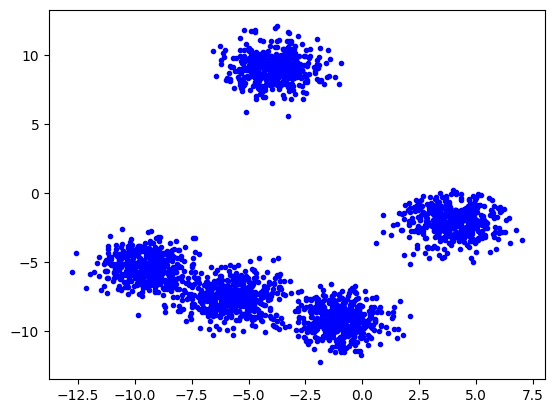

In [4]:
plt.scatter(toydata[:,0], toydata[:,1], c='b', marker='.')

### 2) K-means implementation

Implement the k-means algorithm. Return the estimated cluster means and cluster asssignments of each iteration, not only the final state.

Your algorithm should stop after `max_iters` iterations or when the change in the means of the clusters $$ \sum_{i = 1}^k \| \mu_i^{t+1} - \mu_i^{t} \|^2$$ is less than `tol`.

In [5]:
def kmeans(data, k, max_iters=100, tol=1e-3):
    """
    Implements the K-Means clustering algorithm and tracks the history of centroids and assignments.

    Parameters:
    data (numpy.ndarray): Data points for clustering.
    k (int): Number of clusters.
    max_iters (int): Maximum number of iterations.
    tol (float): Iteration stops if all centroids have moved less than tol

    Returns:
    tuple: (final_centroids, final_cluster_assignments, centroids_history, assignments_history)
    """
    def assignments(data, centroids):
        """ Returns np.array of shape (n_samples) with the centroid index for each data point. """
        distances = np.linalg.norm(data - centroids[:, np.newaxis,:], axis=2)  # data.shape is (n,2) and centroids[:, np.newaxis,:] has shape (k,1,2) -> broadcast to (k,n,2)
        cluster_assignments = np.argmin(distances, axis=0)
        return cluster_assignments
    

    # Randomly initialize centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False), :]  # choose k random data points as centroid inits
    centroids_history = [centroids]
    assignments_history = []

    for _ in range(max_iters):
        # Assign data points to the nearest centroid
        cluster_assignments = assignments(data, centroids)
        assignments_history.append(cluster_assignments)

        # Update centroids
        centroids = np.array([data[cluster_assignments == j].mean(axis=0) for j in range(k)])
        centroids_history.append(centroids)
        
        # Check for convergence (if all centroids do not change more than tol)
        if np.all( np.linalg.norm(centroids_history[-1] - centroids_history[-2], axis=1) < tol):
            print(f'K-means converged to tol {tol} after {len(centroids_history) - 1} iterations.')
            break
    
    # Assign data points to final centroids
    cluster_assignments = assignments(data, centroids)
    assignments_history.append(cluster_assignments)
    
    return centroids, cluster_assignments, centroids_history, assignments_history


Apply your implementation to the Gaussian mixture toy-data, and use the provided ```plot_kmeans_iterations()``` function to visualize how centroids and cluster assignments evolve over the iterations.  
If you like, play around with the number of clusters in the data and in the algorithm, or vary how well-seperated the data clusters are, and observe the k-means dynamics. Do you notice failure modes?

In [6]:
import matplotlib.pyplot as plt

def plot_kmeans_iterations(data, centroids_history, assignments_history):
    """
    Plots K-Means iterations showing centroids and data point assignments.

    Parameters:
    data (np.array of shape (n_samples,2)): Data points.
    centroids_history (list of (k,2) shape np.arrays): List of the centroids at each iteration.
    assignments_history (list of (k) shape np.arrays): List of data point assignments at each iteration.
    """
    n_iters = len(centroids_history)
    plt.figure(figsize=(15, 5 * n_iters))

    for i in range(n_iters):
        plt.subplot(n_iters, 1, i + 1)
        plt.scatter(data[:, 0], data[:, 1], c=assignments_history[i], alpha=0.5, marker='.')
        plt.scatter(centroids_history[i][:, 0], centroids_history[i][:, 1], c='red', marker='X')
        plt.title(f'Iteration {i+1}')
        plt.xlabel('X')
        plt.ylabel('Y')

    plt.tight_layout()
    plt.show()


K-means converged to tol 1e-05 after 8 iterations.


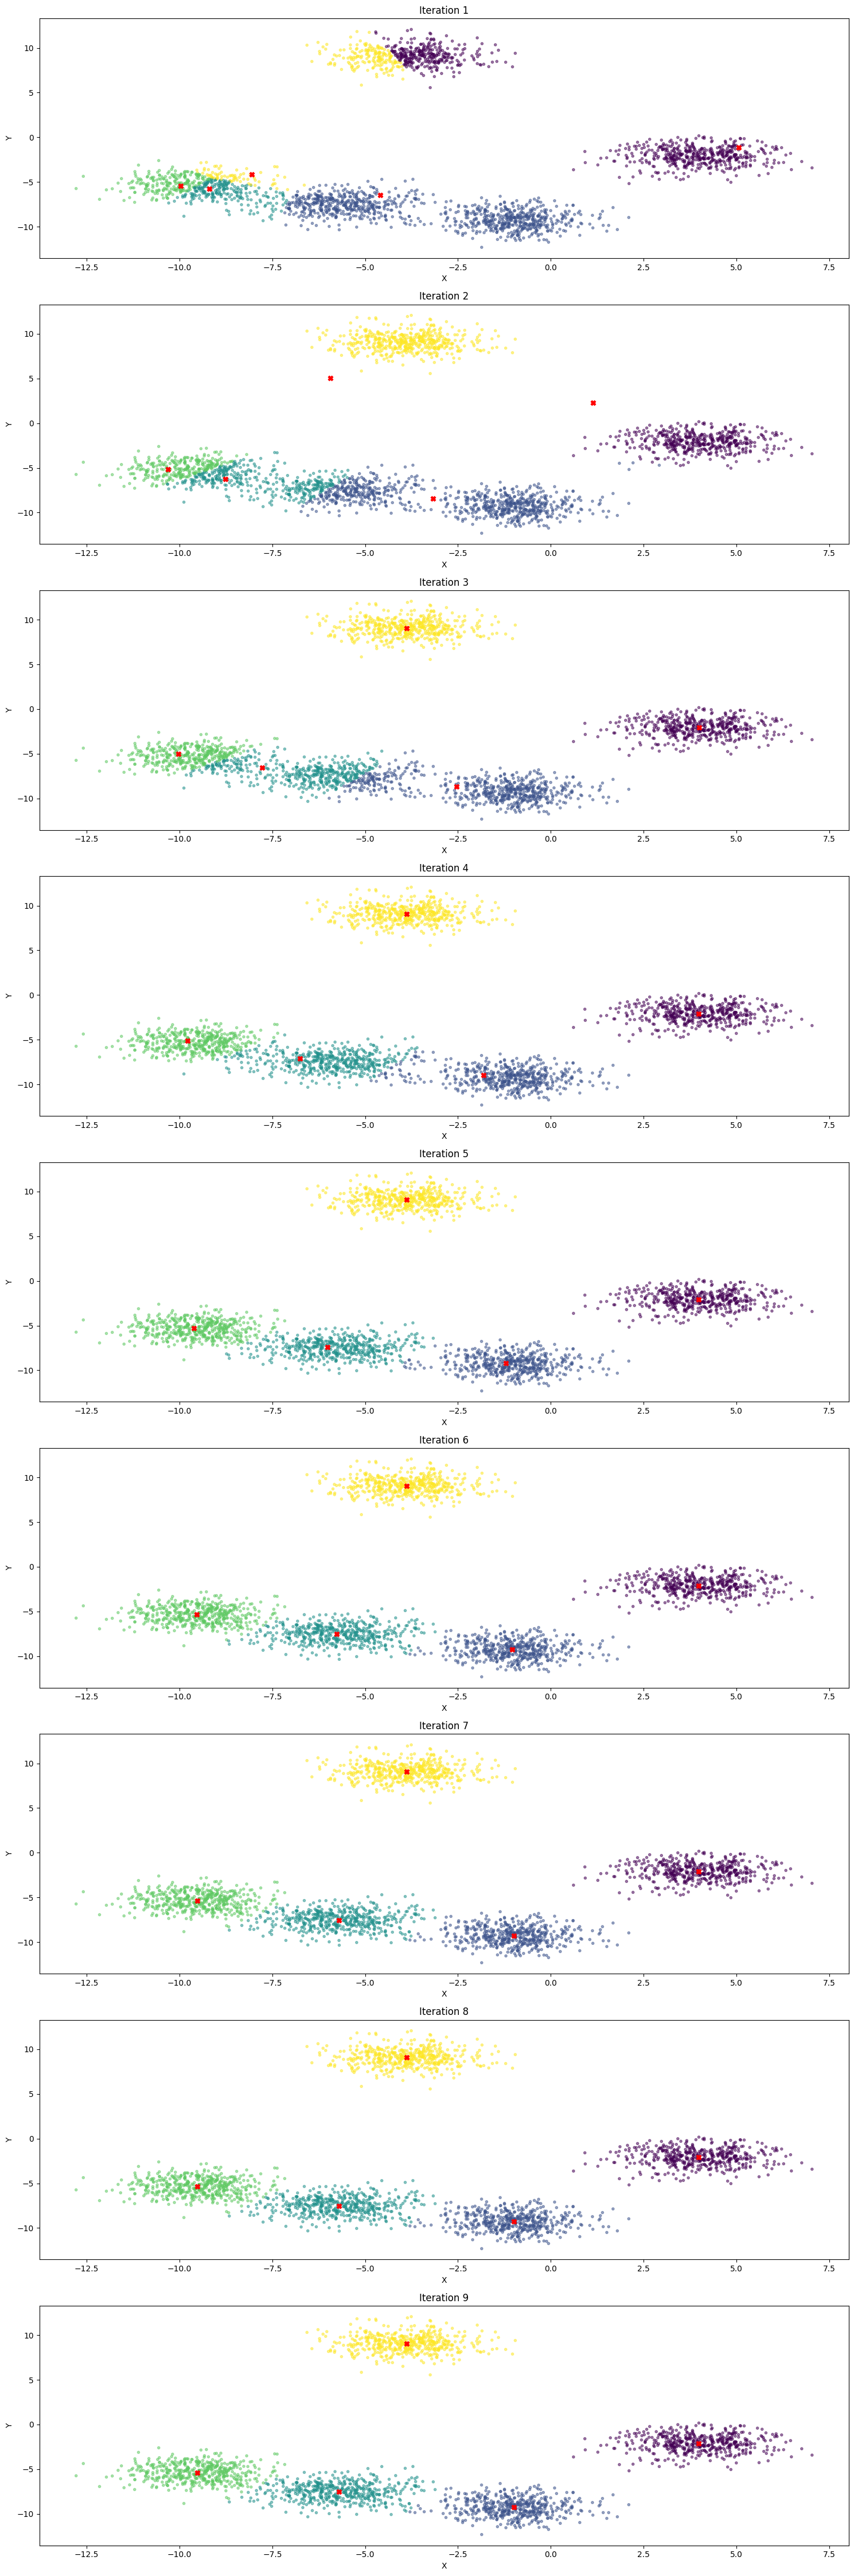

In [7]:
# apply kmeans() to the toy-data and plot the iterations.
cf, af, centr, assigns = kmeans(toydata, k, max_iters=100, tol=1e-5)

plot_kmeans_iterations(toydata, centr, assigns)

### 3) Clustering of pulsar observation data
We now consider a dataset of pulsar candidates from the HTRU survey. You can download the data and read the description of the data on the [UCI machine learning repository](https://archive.ics.uci.edu/dataset/372/htru2). The .csv file is also provided on Moodle with the exercise. Our goal is to see in how far pulsars and false pulsar candidates are represented by two different clusters which we can automatically discover via clustering. While this is a very simple method, k-means has been applied extensively in scientific data analysis, for an example from astrophysics similar to our pulsar candidate clustering here, see [Turner et al. 2019](https://academic.oup.com/mnras/article/482/1/126/5116177) who are clustering galaxy survey data. But now to the pulsar candidates.  


Read the description and familiarize yourself with the data. Load it from the ```.csv``` file, for example using ```np.loadtxt()```, then investigate some basic questions such as:*
- *How many samples and features are there?*
- *What is the mean and variance of the different features?*
- *How many true pulsars and how many non-pulsars are in the data?*

In [8]:
# load the data 
data = np.loadtxt('HTRU_2.csv', delimiter=',')

In [9]:
# explore it a bit
print(f'data shape {data.shape}')
print(f'{data[:,-1].sum()} pulsars and {data.shape[0] - data[:,-1].sum()} non-pulsars')
print(f'mean and std of the features:\n', np.vstack([data[:,:-1].mean(axis=0), data[:,:-1].std(axis=0)]).T)

data shape (17898, 9)
1639.0 pulsars and 16259.0 non-pulsars
mean and std of the features:
 [[111.07996834  25.65221871]
 [ 46.54953156   6.84299824]
 [  0.47785726   1.06400999]
 [  1.770279     6.16774094]
 [ 12.61439966  29.47207378]
 [ 26.3265147   19.47002839]
 [  8.30355612   4.50596597]
 [104.8577087  106.51156389]]


Remove the column containing the labels, since we want to do unsupervised learning. The ground-truth labels will be used later to assess our clustering result.*
* Before using  k-means on the data, preprocess the data by standardizing it, e.g. ```sklearn.preprocessing.StandardScaler```?

In [10]:
# split features and labels
X = data[:,:-1]
y = data[:,-1]

In [11]:
# preprocess by standardizing
import sklearn.preprocessing
scaler =  sklearn.preprocessing.StandardScaler().fit(X)
X_s = scaler.transform(X)

Look for the k-means implementation in sklearn and apply it to the data. Use n_clusters=2.

In [12]:
import sklearn.cluster
skmeans = sklearn.cluster.KMeans(n_clusters=2)
skmeans.fit(X_s)

KMeans(n_clusters=2)

Get the cluster assignment of each sample. We want to compare these to the true labels and evaluate the performance of our clustering. To do so, we'll use the [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) from `sklearn`

In [13]:
y_pred = skmeans.labels_

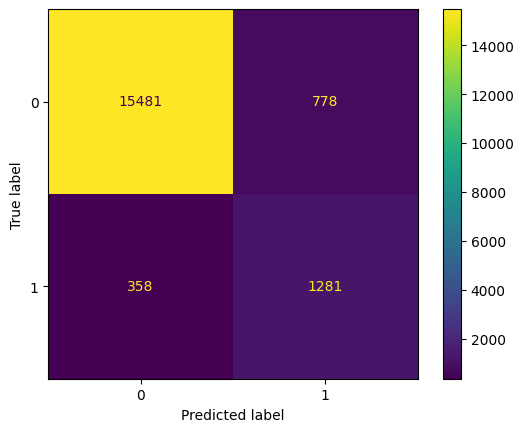

In [14]:
cm = sklearn.metrics.confusion_matrix(y, y_pred)

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [15]:
np.max([sklearn.metrics.accuracy_score(y_pred, y), 
        sklearn.metrics.accuracy_score(-(y_pred -1), y)]) 

0.9365292211420271

Use the plotting function provided below, and inspect the resulting 2d slices of the clusters colored by cluster index and true label. Read through the function to see how it handles the coloring and plotting.

In [16]:
def plot_pulsar_clusters_vs_labels(X, y, y_pred):
    """
    Plots the results of k-means clustering against actual labels.

    This function visualizes the comparison between k-means clustering predictions 
    (y_pred) and actual labels (y) for each pair of features in the dataset. 
    It uses different colors to indicate true positives, true negatives, false negatives,
    and false positives.

    Parameters:
    X (numpy.ndarray): The feature data set. Each row represents a sample, 
                       and each column represents a feature.
    y (numpy.ndarray): The actual labels for each sample. This array is 1-dimensional.
    y_pred (numpy.ndarray): The predicted labels from k-means clustering. 
                            This array is 1-dimensional.

    The function creates scatter plots for each pair of features in the data set.
    """
    
    feature_names = ['Mean of the integrated profile',
                     'Standard deviation of the integrated profile',
                     'Excess kurtosis of the integrated profile',
                     'Skewness of the integrated profile',
                     'Mean of the DM-SNR curve',
                     'Standard deviation of the DM-SNR curve',
                     'Excess kurtosis of the DM-SNR curve',
                     'Skewness of the DM-SNR curve']

    # making a coloring array for scatterplots
    lightred = np.array([0.9, 0, 0])
    red = np.array([0.4, 0, 0])
    yellow = np.array([0.9, 0.9, 0])
    blue = np.array([0, 0, 0.9])

    data_coloring = np.zeros((y.size, 3))
    data_coloring[(y_pred == 1) & (y == 1)] = yellow  # True positive
    data_coloring[(y_pred == 0) & (y == 0)] = blue    # True negative
    data_coloring[(y_pred == 0) & (y == 1)] = red     # False negative
    data_coloring[(y_pred == 1) & (y == 0)] = lightred # False positive

    for i in range(4):
        dims = [2 * i, 2 * i + 1]
        plt.figure(figsize=(8, 6))
        plt.title('k-means prediction vs. label')
        plt.scatter(X[:, dims[0]], X[:, dims[1]], c=data_coloring, marker='.', alpha=0.6)
        plt.xlabel(feature_names[dims[0]])
        plt.ylabel(feature_names[dims[1]])

        # Adding legend
        plt.scatter([], [], color=yellow, label='True Positive')
        plt.scatter([], [], color=blue, label='True Negative')
        plt.scatter([], [], color=red, label='False Negative')
        plt.scatter([], [], color=lightred, label='False Positive')
        plt.legend()

        plt.show()


In [17]:
# in case the skmeans 0 labels correspond best to the ground truth 1 label, flip them 
if sklearn.metrics.accuracy_score(y_pred, y) < sklearn.metrics.accuracy_score(-(y_pred -1), y):
    y_pred = -(skmeans.labels_ - 1)

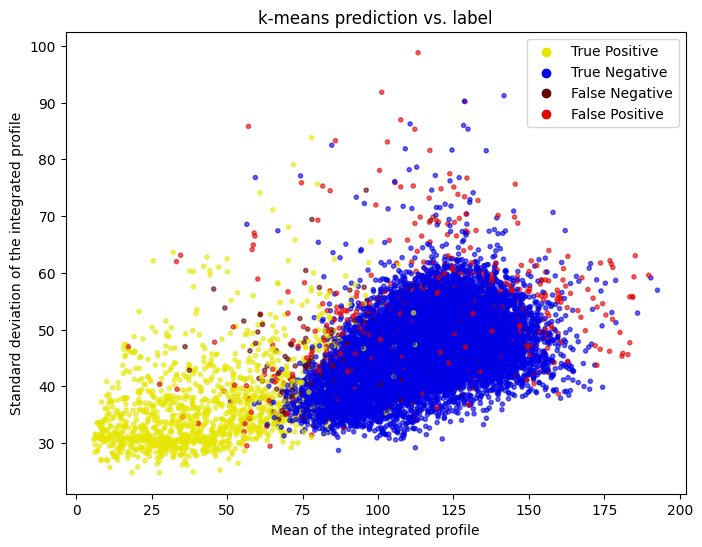

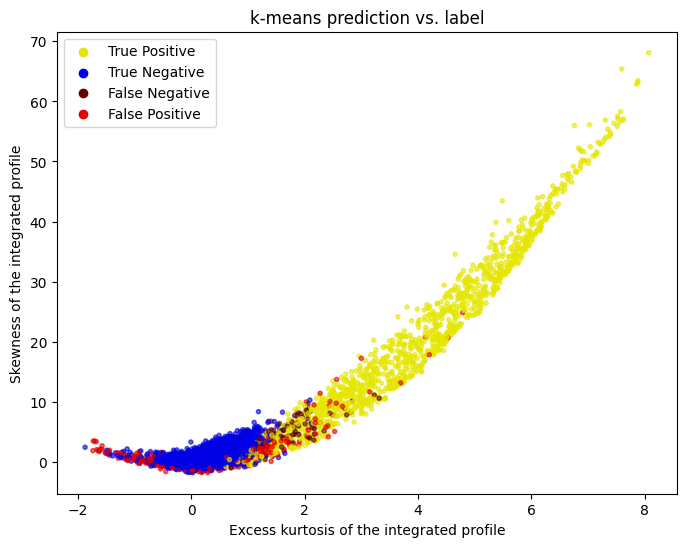

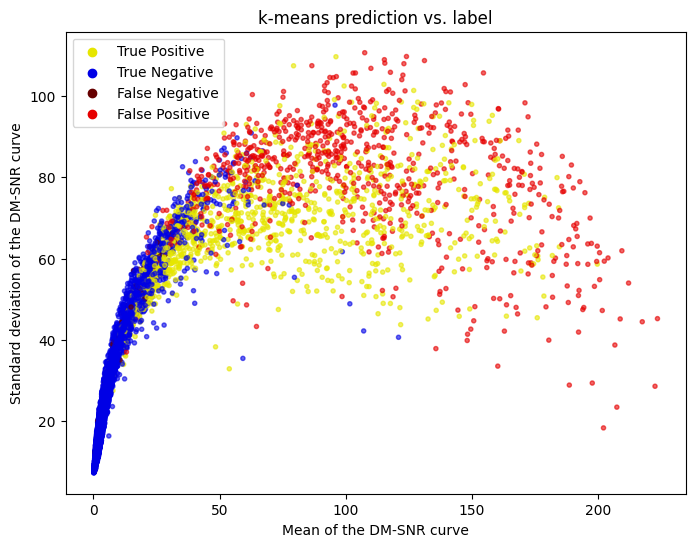

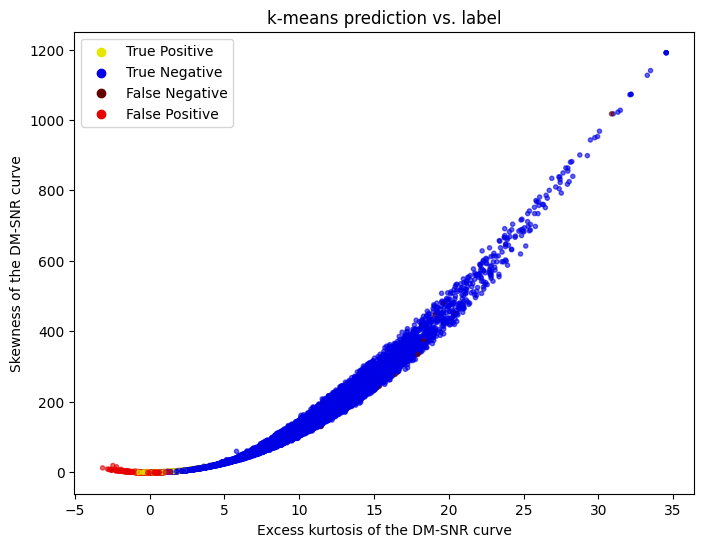

In [18]:
plot_pulsar_clusters_vs_labels(X, y, y_pred)